In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.metrics import LogLoss


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from imblearn.under_sampling import RandomUnderSampler

import sys




def preprocess_data(filename):
    data = pd.read_csv(filename)
    
    def separate_features(dataframe):
        categorical_features = []
        continuous_features = []

        for column in dataframe.columns:
            if dataframe[column].dtype == 'object' or dataframe[column].dtype.name == 'category':
                categorical_features.append(column)
            elif dataframe[column].dtype == 'int64' or dataframe[column].dtype == 'float64':
                continuous_features.append(column)
            else:
                print(f'Unhandled data type in column "{column}": {dataframe[column].dtype}')

        return categorical_features, continuous_features




    data = data[data['loan_status'].isin(['Fully Paid','Charged Off','Defaulted'])]
    leakage_features = [
        'out_prncp',
        'out_prncp_inv',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'recoveries',
        'collection_recovery_fee',
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'last_credit_pull_d',
        'debt_settlement_flag',
        'debt_settlement_flag_date',
        'settlement_status',
        'settlement_date',
        'settlement_amount',
        'settlement_percentage',
        'settlement_term',
        'last_fico_range_high',
        'last_fico_range_low',
        'id',
        'url',
        'emp_title',
        'title'
    ]

    # Drop the leakage features
    data = data.drop(leakage_features, axis=1)

    # Calculate the percentage of missing values for each feature
    missing_values = data.isnull().sum() / len(data) * 100

    # Identify columns with more than 90% missing values
    columns_to_drop = missing_values[missing_values > 90].index

    # Drop the identified columns
    data = data.drop(columns_to_drop, axis=1)

    categorical_features, continuous_features = separate_features(data)
    categorical_features.remove('loan_status')
    
    
    # fill numeric NAs with median
    #median_values = data[continuous_features].median() 
    #data[continuous_features] = data[continuous_features].fillna(median_values)
    data[continuous_features] = data[continuous_features].fillna(-1)
    
    
    # Fill categorical NAs with "missing" and convert all elements to strings
    data[categorical_features] = data[categorical_features].fillna('missing').astype(str)

    
    
    data_not_encoded = data.copy()
    
    
    
    for feature in categorical_features:
        label_encoder = LabelEncoder()
        data[feature] = label_encoder.fit_transform(data[feature])
    


    # Preprocess loan status labels with custom encoding
    custom_encoding = {
        'Fully Paid': 0,
        'Charged Off': 1,
        'Default': 1,
    
    }
    data['loan_status'] = data['loan_status'].replace(custom_encoding)
    
    
    
    
    return data, data_not_encoded

#a=torch.cuda.FloatTensor()
display(torch.cuda.is_available())
#sys.exit()

filename = 'accepted_2007_to_2018Q4.csv'
df, data_not_encoded = preprocess_data(filename)

X = df.drop(columns=['loan_status']).values
y = df['loan_status'].values

# model path
model_path = 'tabnet_model.pth.zip'

# Load the model
tabnet_model = TabNetClassifier()
tabnet_model.load_model(model_path)

#Split the dataset
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Create an array that holds the original indices
original_indices = df.index.values

#Split the dataset, but also split the original_indices array in the same way
X_train_val, X_test, y_train_val, y_test, original_indices_train_val, original_indices_test = train_test_split(X, y, original_indices, test_size=0.2, random_state=42, stratify=y)

# Further split the training set and the indices
X_train, X_val, y_train, y_val, original_indices_train, original_indices_val = train_test_split(X_train_val, y_train_val, original_indices_train_val, test_size=0.25, random_state=42, stratify=y_train_val)


#Undersample the training set
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

y_val_pred_proba = tabnet_model.predict_proba(X_val)



True

C:\Users\Carlo Alberto\AppData\Local\Temp\ipykernel_6464\3354317031.py:29: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename)
E:\Anaconda\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


  0%|          | 0/1000 [00:00<?, ?it/s]

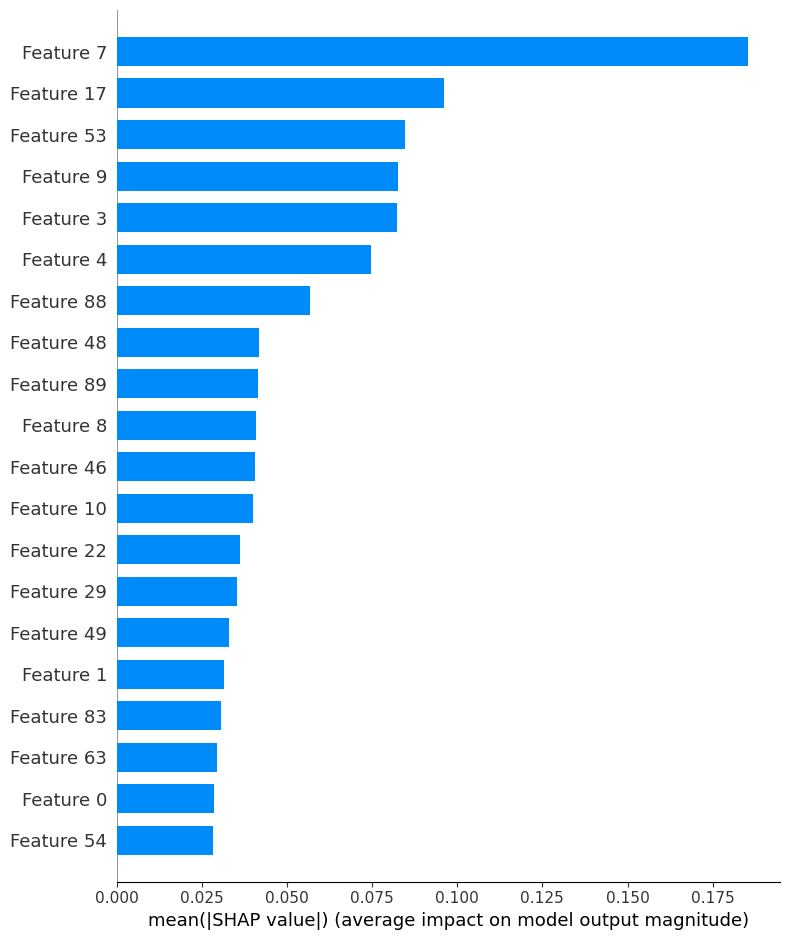

In [7]:
import shap
import numpy as np

# Define the size of the sample for the explainer
sample_size = 500  # adjust this as needed

# Randomly choose sample_size indices from the training data
sample_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)

# Create a subset of the training data using these indices
X_train_subset = X_train[sample_indices, :]

# Summarize the subset further
X_train_summary = shap.kmeans(X_train_subset, 50)  # Use 50 cluster centers

# Create the explainer using the summarized subset of training data
explainer = shap.KernelExplainer(tabnet_model.predict, X_train_summary)

# The rest of the code remains the same...

# Choose a subset of your validation data
subset_indices = np.random.choice(X_val.shape[0], 1000, replace=False)
X_val_subset = X_val[subset_indices, :]

# Calculate Shapley values
shap_values_subset = explainer.shap_values(X_val_subset)

# Plot global interpretability summary
shap.summary_plot(shap_values_subset, X_val_subset, plot_type="bar")


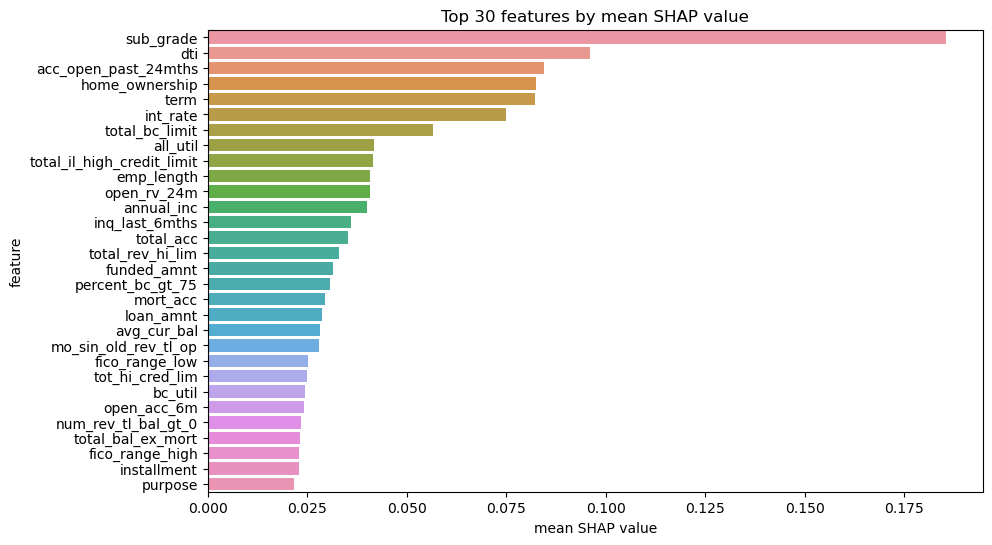

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming that you already calculated shap_values_subset

# Get feature names
feature_names = df.drop(columns=['loan_status']).columns

# Sum absolute SHAP values for each feature
shap_sum = np.abs(shap_values_subset).mean(axis=0)


# Sort
indices = np.argsort(shap_sum)

# Create a DataFrame for visualization
importance_df = pd.DataFrame([feature_names[i] for i in indices[::-1]], columns=['feature'])
importance_df['mean SHAP value'] = shap_sum[indices[::-1]]

# Only take the top N
top_N = 30
top_features = importance_df.iloc[:top_N]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='mean SHAP value', y='feature', orient='h')
plt.title(f'Top {top_N} features by mean SHAP value')
plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

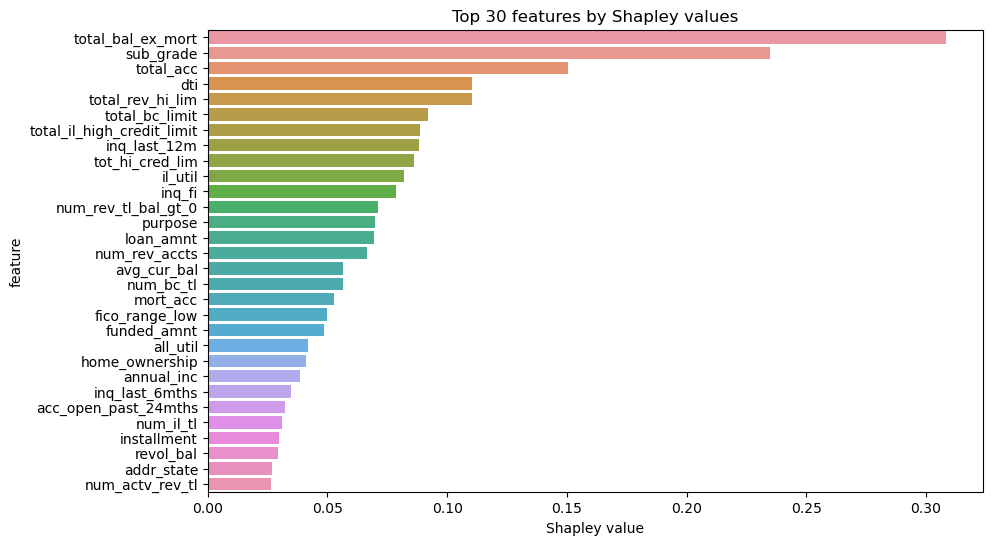


Top 10 feature importances (Shapley values) and their values for this sample:
total_bal_ex_mort (importance: 0.3083123196377949): 296613.0
sub_grade (importance: 0.23501556096152165): D4
total_acc (importance: 0.15055431453560109): 74.0
dti (importance: 0.1105325347093512): 26.91
total_rev_hi_lim (importance: 0.11037760493361054): 103600.0
total_bc_limit (importance: 0.09201209840053792): 48500.0
total_il_high_credit_limit (importance: 0.08849748223438825): 244248.0
inq_last_12m (importance: 0.0883788281810653): 12.0
tot_hi_cred_lim (importance: 0.08617235347408414): 736987.0
il_util (importance: 0.08181433527184079): 43.0


  0%|          | 0/1 [00:00<?, ?it/s]

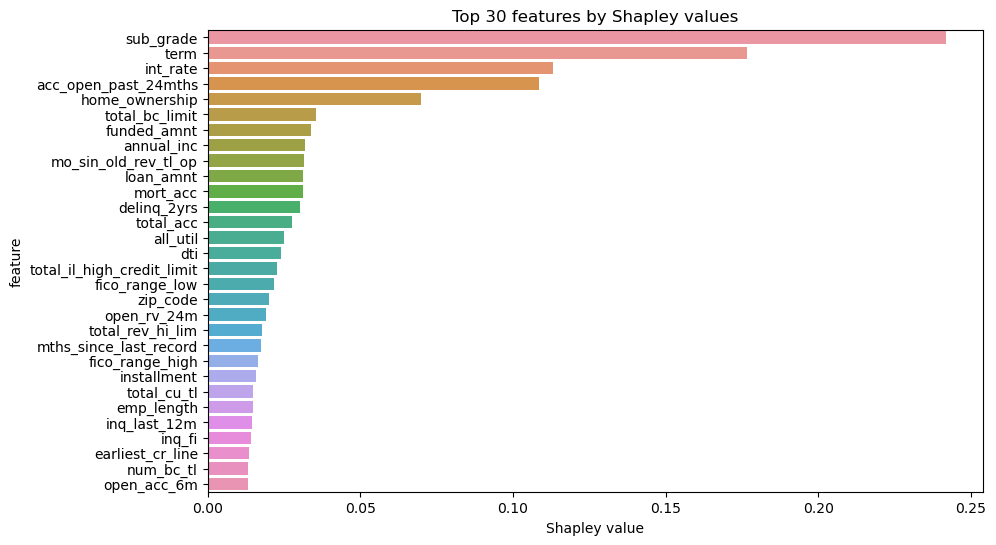


Top 10 feature importances (Shapley values) and their values for this sample:
sub_grade (importance: 0.24173076522176012): E4
term (importance: 0.17673931494521472):  60 months
int_rate (importance: 0.11313546014977295): 19.99
acc_open_past_24mths (importance: 0.108446168133155): 9.0
home_ownership (importance: 0.06979936907530981): RENT
total_bc_limit (importance: 0.035364526004623364): 9100.0
funded_amnt (importance: 0.03367292154905055): 24000.0
annual_inc (importance: 0.03172770927506313): 90000.0
mo_sin_old_rev_tl_op (importance: 0.03147449335197444): 48.0
loan_amnt (importance: 0.03109156060590379): 24000.0


  0%|          | 0/1 [00:00<?, ?it/s]

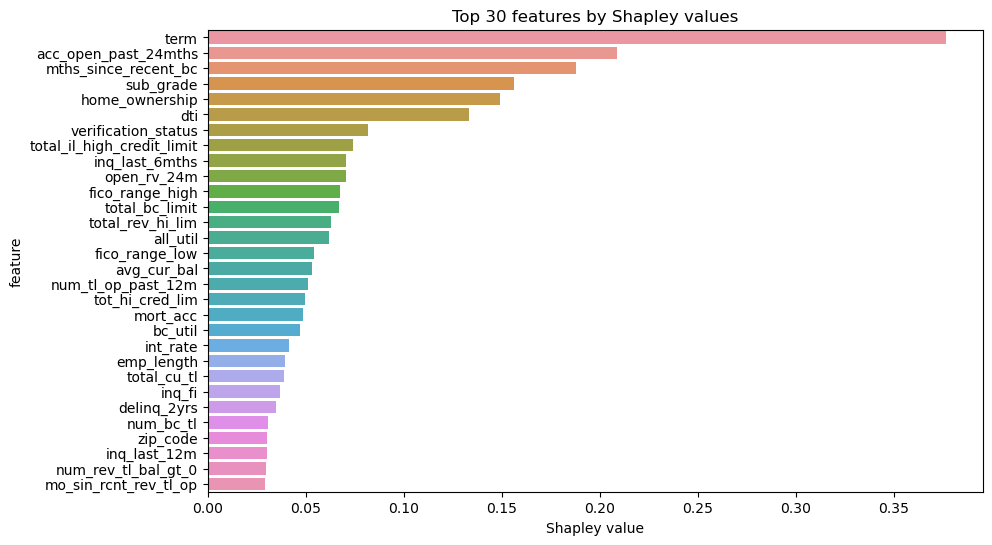


Top 10 feature importances (Shapley values) and their values for this sample:
term (importance: 0.37669362976596354):  60 months
acc_open_past_24mths (importance: 0.2086448151655991): 2.0
mths_since_recent_bc (importance: 0.18792651409264727): 120.0
sub_grade (importance: 0.15631708270895475): C5
home_ownership (importance: 0.14924530667222563): MORTGAGE
dti (importance: 0.13331713805441528): 24.32
verification_status (importance: 0.08165644627246856): Not Verified
total_il_high_credit_limit (importance: 0.07387678728034713): 52881.0
inq_last_6mths (importance: 0.07060514789356441): 0.0
open_rv_24m (importance: 0.07044615290444103): -1.0


  0%|          | 0/1 [00:00<?, ?it/s]

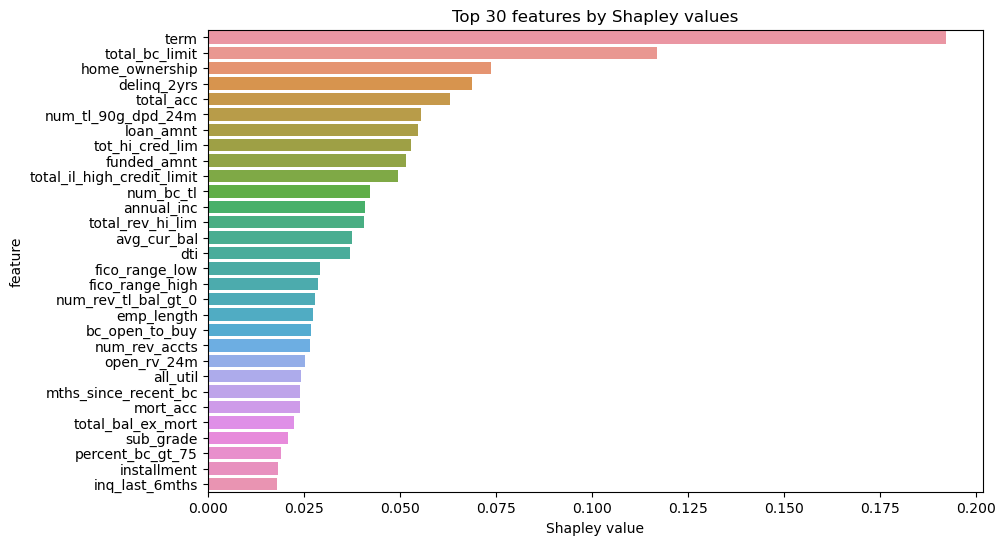


Top 10 feature importances (Shapley values) and their values for this sample:
term (importance: 0.19207228587674738):  60 months
total_bc_limit (importance: 0.11686294990225754): 47700.0
home_ownership (importance: 0.07372367700983012): MORTGAGE
delinq_2yrs (importance: 0.06879593874275544): 2.0
total_acc (importance: 0.06299492994058123): 43.0
num_tl_90g_dpd_24m (importance: 0.05554982171226952): 2.0
loan_amnt (importance: 0.05480223680329649): 30000.0
tot_hi_cred_lim (importance: 0.05297459729934652): 445761.0
funded_amnt (importance: 0.05164371599191514): 30000.0
total_il_high_credit_limit (importance: 0.0495818860353866): 72067.0


In [12]:
def plot_shap_for_sample(sample, feature_names, original_index, top_N=30):
    # Compute Shapley values for this sample
    shap_values = explainer.shap_values(sample.reshape(1, -1))

    # Then we create a DataFrame that we'll use for plotting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'Shapley value': np.abs(shap_values[0])  # Use absolute value to measure the impact of each feature
    })
    
    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values('Shapley value', ascending=False)
    
    top_features = importance_df.iloc[:top_N]

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_features, x='Shapley value', y='feature', orient='h')
    plt.title(f'Top {top_N} features by Shapley values')
    plt.show()

    # Print top 10 feature importances and corresponding feature values for this sample
    top_10_features = importance_df.iloc[:10]
    print("\nTop 10 feature importances (Shapley values) and their values for this sample:")
    for _, row in top_10_features.iterrows():
        feature = row['feature']
        importance = row['Shapley value']
        feature_value = data_not_encoded.loc[original_index, feature]
        print(f"{feature} (importance: {importance}): {feature_value}")

# The rest of the code remains the same...
# Get feature names
feature_names = df.drop(columns=['loan_status']).columns

# Get the predictions for the test set
y_pred_proba = tabnet_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get indices of correctly predicted positive and negative samples
correct_positive_indices = np.where((y_test == 1) & (y_pred == 1))[0]
correct_negative_indices = np.where((y_test == 0) & (y_pred == 0))[0]

# Set random seed for reproducibility
np.random.seed(42)

# Randomly select 2 positive and 2 negative samples
selected_positive_indices = np.random.choice(correct_positive_indices, 2, replace=False)
selected_negative_indices = np.random.choice(correct_negative_indices, 2, replace=False)


# Combine selected indices
selected_indices = np.concatenate([selected_positive_indices, selected_negative_indices])

# Plot importances for each sample
for idx in selected_indices:
    original_index = original_indices_test[idx]
    sample = X_test[idx]
    plot_shap_for_sample(sample, feature_names, original_index)
